In [1]:
import numpy as np
import pandas as pd
import awkward as ak
import tensorflow as tf
import matplotlib.pyplot as plt
import topcoffea.modules.utils as utils
import pickle
import gzip
import logging
import time

2025-03-28 15:13:00.208180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rando = 1234

In [3]:
fSMEFT = "/afs/crc.nd.edu/user/h/hnelson2/dctr/analysis/dctr_SMEFT.pkl.gz"
fpowheg = "/afs/crc.nd.edu/user/h/hnelson2/dctr/analysis/dctr_powheg.pkl.gz" 

In [4]:
inputs_smeft= pickle.load(gzip.open(fSMEFT)).get()
inputs_powheg = pickle.load(gzip.open(fpowheg)).get()
inputs_powheg = inputs_powheg.sample(frac=1, random_state=rando).reset_index(drop=True)

In [5]:
smeft_train = inputs_smeft.sample(frac=0.7, random_state=rando)
smeft_test = inputs_smeft.drop(smeft_train.index)

powheg_train = inputs_powheg.iloc[:1958489].sample(frac=0.7, random_state=rando)
powheg_test = inputs_powheg.iloc[:1958489].drop(powheg_train.index)

truth_smeft = np.ones_like(smeft_train['weights'])
truth_powheg = np.zeros_like(powheg_train['weights'])

weights_smeft = smeft_train['weights']
weights_powheg = powheg_train['weights']

In [6]:
z_0 = smeft_train
z_1 = powheg_train
w_0 = z_0['weights']
w_1 = z_1['weights']
y_0 = np.ones_like(z_0['weights'])
y_1 = np.zeros_like(z_1['weights'])

z = np.concatenate([z_0, z_1], axis=0).astype(np.float32)
w = np.concatenate([w_0, w_1], axis=0).astype(np.float32)
y = np.concatenate([y_0, y_1], axis=0).astype(np.float32)

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((z, y, w)).shuffle(len(z)).batch(128)
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(z)

2025-03-28 15:23:11.634683: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 64. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Define the neural network model
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(0.2, seed=rando),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# Define custom loss function
def custom_loss(y_true, y_pred, weights):
    term_1 = tf.reduce_sum(weights * y_true * -tf.math.log(y_pred + 1e-8))
    term_0 = tf.reduce_sum(weights * (1 - y_true) * -tf.math.log(1 - y_pred + 1e-8))
    return term_1 + term_0

In [10]:
input_dim = z.shape[1]
model = create_model(input_dim)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [15]:
model.compile(
    optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
nepochs = 10
model.fit(z, y, epochs=nepochs)

Epoch 1/10
85684/85684 [==============================] - 94s 1ms/step - loss: 0.6380 - accuracy: 0.6428
Epoch 2/10
85684/85684 [==============================] - 99s 1ms/step - loss: 0.6371 - accuracy: 0.6445
Epoch 3/10
85684/85684 [==============================] - 105s 1ms/step - loss: 0.6364 - accuracy: 0.6455
Epoch 4/10
85684/85684 [==============================] - 112s 1ms/step - loss: 0.6360 - accuracy: 0.6462
Epoch 5/10
85684/85684 [==============================] - 114s 1ms/step - loss: 0.6359 - accuracy: 0.6464
Epoch 6/10
85684/85684 [==============================] - 100s 1ms/step - loss: 0.6357 - accuracy: 0.6466
Epoch 7/10
85684/85684 [==============================] - 85s 989us/step - loss: 0.6356 - accuracy: 0.6467
Epoch 8/10
85684/85684 [==============================] - 86s 1ms/step - loss: 0.6356 - accuracy: 0.6468
Epoch 9/10
85684/85684 [==============================] - 81s 946us/step - loss: 0.6355 - accuracy: 0.6470
Epoch 10/10
85684/85684 [======================

In [17]:
def compute_r(z):
    f_z = model.predict(z)
    return f_z / (1 - f_z + 1e-8)

In [18]:
r_z_0 = compute_r(z_0)

42842/42842 [==============================] - 18s 426us/step


In [19]:
r_z_1 = compute_r(z_1)

42842/42842 [==============================] - 18s 409us/step


In [20]:
# Reweighting and closure test
weights_0_to_1 = w_0 * r_z_0.flatten()
weights_1_to_0 = w_1 / (r_z_1.flatten() + 1e-8)

/tmp/ipykernel_1072042/774406114.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


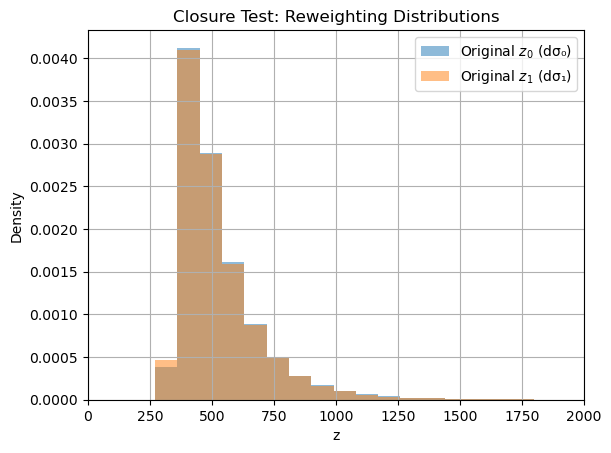

In [28]:
# Make histograms
bins = np.linspace(0, np.max([z_0.max(), z_1.max()]), 50)
fig,ax = plt.subplots()

# Original distributions
plt.hist(z_0['mtt'], bins=bins, weights=w_0, alpha=0.5, label="Original $z_0$ (dσ₀)", density=True)
plt.hist(z_1['mtt'], bins=bins, weights=w_1, alpha=0.5, label="Original $z_1$ (dσ₁)", density=True)

# Reweighted distributions
# plt.hist(z_0['mtt'], bins=bins, weights=weights_0_to_1, histtype='step', lw=2, label="Reweighted $z_0 \\to dσ₁$", density=True)
# plt.hist(z_1['mtt'], bins=bins, weights=weights_1_to_0, histtype='step', lw=2, label="Reweighted $z_1 \\to dσ₀$", density=True)

# Plot settings
ax.set_xlim([0,2000])
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("Closure Test: Reweighting Distributions")
plt.grid()
fig.show()
# fig.savefig("dnn_output.png")